<a href="https://colab.research.google.com/github/stefsyrsiri/ai-image-detection/blob/AGalanopoulou/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In progress** Deep learning project for the "Deep Learning" course of the MSc "Data Science".

Working with Anna! :)

In [ ]:
## test Anna

In [ ]:
# Project overview
# 1. SVM
# 2. CNN
# 3. Transfer learning

In [41]:
# Import packages
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode,v2
import cv2
torch.manual_seed(42)

In [ ]:
# Datasets
# We have 2 candidate datasets with real and synthetic images
# CIFAKE: Real and AI-Generated Synthetic Images
# https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
#
# ArtiFact (no kaggle url - only kaggle API)
# !kaggle datasets download -d awsaf49/artifact-dataset
# We should also import and take a look at ArtiFact to see which dataset we prefare
# Took a look at ArtiFact. Much much bigger dataset with a lot datasets inside. Let's work with the simpler dataset first and try the other one if we have enough time.
#
# Using a kaggle key for now. Also using an input function to avoid storing the key in the code
# Whoever wants to run their code has to input their own key (Stef/Anna/TG) - we can change this later
KAGGLE_USERNAME = input("Enter your Kaggle username: ")
KAGGLE_KEY = input("Enter your Kaggle key: ")

os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [3]:
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 97% 101M/105M [00:03<00:00, 40.5MB/s] 
100% 105M/105M [00:03<00:00, 28.0MB/s]


In [5]:
# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

In [6]:
!ls

cifake-real-and-ai-generated-synthetic-images.zip  sample_data	test  train


In [7]:
!find . -type d

.
./.config
./.config/configurations
./.config/logs
./.config/logs/2024.05.28
./test
./test/FAKE
./test/REAL
./train
./train/FAKE
./train/REAL
./sample_data


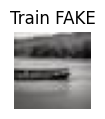

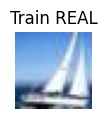

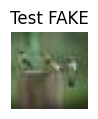

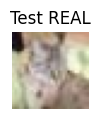

In [8]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[0])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [9]:
# Classes' labels
LABELS = np.asarray(os.listdir('train'))
print(LABELS)

['FAKE' 'REAL']


In [10]:
# Create the training and test datasets with ImageFolder class from PyTorch in comparison to creating custom datasets
# TODO: Add transformation
# Training dataset
train_dataset = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set:\n{train_dataset}\n")

# Validation dataset
valid_dataset = datasets.ImageFolder(root='test')
print(f"Validation set:\n{valid_dataset}")

Training set:
Dataset ImageFolder
    Number of datapoints: 100000
    Root location: train

Validation set:
Dataset ImageFolder
    Number of datapoints: 20000
    Root location: test


Applying transformations and visualizing them helps ensure that the data preprocessing
and augmentation pipeline is correctly implemented.
It also ensures that the transformations are enhancing the dataset in a way that will help the model generalize better to new data,
ultimately improving the model's performance and robustness.

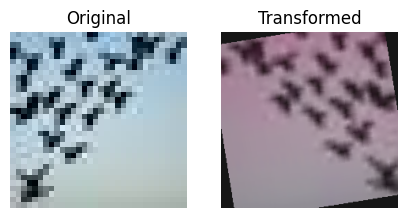

In [32]:

transform = v2.Compose([
    # resize image to 232 x 232
    ## all images have a uniform size, which is required for batch processing in neural networks
    v2.Resize(size=(232, 232), interpolation=InterpolationMode.BILINEAR, antialias=True),
    ##ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.
    v2.CenterCrop(224),

    # data augmentation

    ##Flips the image horizontally with a probability of 0.5. This helps the model become invariant to the horizontal orientation of objects, increasing its robustness.
    v2.RandomHorizontalFlip(p=0.5),

    ##Rotates the image by up to 30 degrees randomly. This adds variation to the dataset, helping the model learn to recognize objects from different angles.
    v2.RandomRotation(degrees=30),

    ##Randomly changes the brightness and contrast of the image, simulating different lighting conditions. This makes the model more robust to changes in lighting in real-world scenarios.
    v2.ColorJitter(brightness=.3, contrast = 0.3),

    ## Randomly permutes the RGB channels, which can help the model become invariant to color variations. This is especially useful if color is not a crucial feature for classification.
    v2.RandomChannelPermutation(),

    # convert PIL image to tensor with image values in [0, 1]
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img, label = train_dataset[2]

transformed_img = transform(img)

fig = plt.figure(figsize=(5, 3))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original")

fig.add_subplot(1, 2, 2)
plt.imshow(transformed_img)
plt.axis('off')
plt.title("Transformed")
plt.show()

In [39]:
# Pretrained model for feature extraction
def extract_deep_features(image, model):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        features = model(image)
    return features.squeeze().numpy()



Check the erro for the path

In [60]:
# Transform the image
transformed_img = transform(img)

# Convert the transformed image to a tensor and add a batch dimension
transformed_img = transforms.ToTensor()(transformed_img)
transformed_img = transformed_img.unsqueeze(0)

In [61]:

#img_path = train_dataset[2]

img_path, label = train_dataset.imgs[2]

img = Image.open(img_path)

transformed_img = transform(img).unsqueeze(0)  # Add batch dimension

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Remove the final classification layer to get feature extractor
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# Ensure the model is in evaluation mode
feature_extractor.eval()

# Extract features
with torch.no_grad():
    features = feature_extractor(transformed_img).squeeze()

# Convert features to a numpy array for further processing if needed
features_np = features.numpy()

# Visualize the original and transformed images
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

fig.add_subplot(1, 2, 2)
transformed_img_np = transformed_img.squeeze().permute(1, 2, 0).numpy()
transformed_img_np = np.clip((transformed_img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])), 0, 1)
plt.imshow(transformed_img_np)
plt.axis('off')
plt.title("Transformed Image")
plt.show()

# Print the shape of the extracted features
print(f"Extracted features shape: {features_np.shape}")

AttributeError: unsqueeze

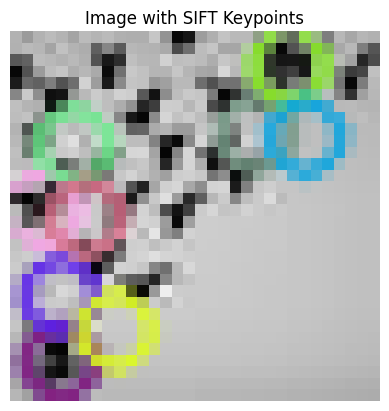

In [36]:
 ##Scale-Invariant Feature Transform (SIFT) algorithm to detect and visualize keypoints in a grayscale version of the image. --SIFT works on single-channel images, so the RGB image is converted to grayscale.
gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints
kp = sift.detect(gray, None)

# Draw keypoints on the image
img = cv2.drawKeypoints(gray, kp, None)

# Convert image from BGR to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with keypoints using matplotlib
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Image with SIFT Keypoints')
plt.show()

In [ ]:
# Feature engineering

In [11]:
# Batch size - change if we get an Out Of Memory error
BATCH_SIZE = 64

# Training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

In [ ]:
# SVM

In [12]:
# Neural net architecture
# TG said that we should save our classes to another file and import them for the report
class DummyClassifier(nn.Module):
    def __init__(self):
        super(DummyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) ## (input channel size ( based on color channels of the image), output channel size, kernel size)
        self.pool = nn.MaxPool2d(2, 2) ## (kernel size ,stride)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = DummyClassifier()

In [ ]:
# Transfer learning